# File and libraries

In [26]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_msg_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

sample_filepath=f"{filepath}_sample.csv"
test_sample_filepath=f"{filepath}_test_sample.csv"
train_sample_filepath=f"{filepath}_train_sample.csv"

file_tag = "Ecom Multichannel messages"

# DSLabs functions

In [27]:
%run "scripts/dslabs_functions.py"


# Data functions

In [28]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [29]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
else:
    # data=pd.read_csv(f"{filepath}.csv")  
    # test= pd.read_csv(test_filepath)
    # train= pd.read_csv(train_filepath)

    # use sample file when heavy processing
    data=pd.read_csv(sample_filepath)
    test= pd.read_csv(test_sample_filepath)
    train= pd.read_csv(train_sample_filepath)
 
 
target='is_clicked'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27258 entries, 0 to 27257
Data columns (total 42 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   event_name                       27258 non-null  float64
 1   device_category                  27258 non-null  float64
 2   device_mobile_brand_name         27258 non-null  float64
 3   device_mobile_model_name         27258 non-null  float64
 4   device_operating_system          27258 non-null  float64
 5   device_operating_system_version  27258 non-null  float64
 6   device_language                  27258 non-null  float64
 7   device_web_info_browser          27258 non-null  float64
 8   device_web_info_browser_version  27258 non-null  float64
 9   geo_region                       27258 non-null  float64
 10  geo_city                         27258 non-null  float64
 11  traffic_source_medium            27258 non-null  float64
 12  traffic_source_source  

# Distribution Check

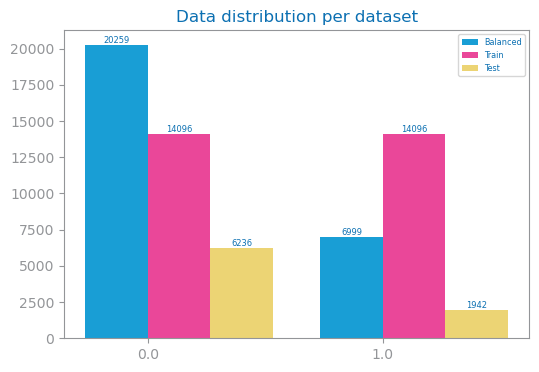

In [30]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

# evaluate prep

In [31]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=28192 Test#=8178
Labels=[0.0, 1.0]


In [32]:
max_trees_eval=350
max_trees_eval_lag=75

# F2 Evaluate for best model

## f2 study

GB best for 100 trees (d=2 and lr=0.1


<Figure size 640x480 with 0 Axes>

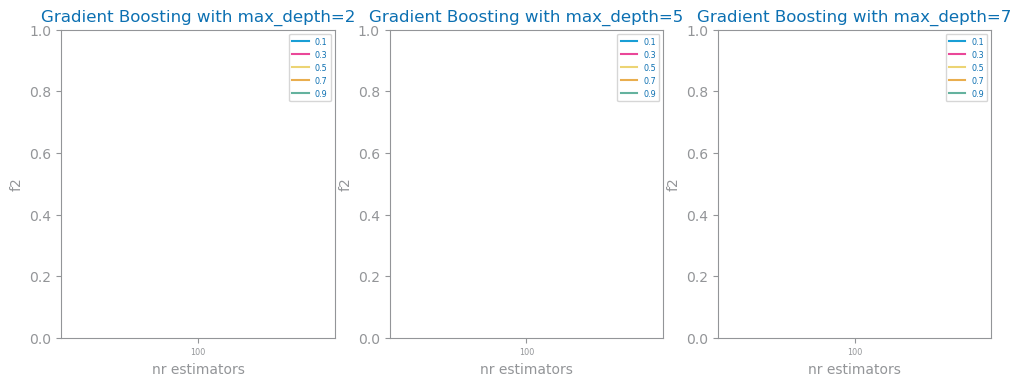

In [33]:
figure()


best_model_f2, f2_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
)

savefig(f'images/{file_tag}_GB_{f2_params['metric']}_study.png')
show()
    

## f2 Best Model Performance

<Figure size 640x480 with 0 Axes>

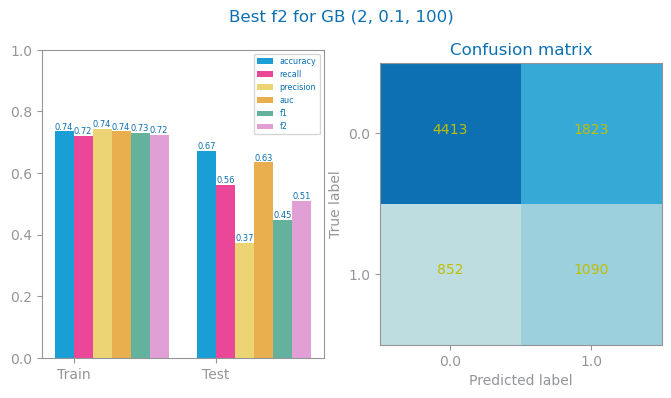

In [34]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_GB_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

## f2 Variables importance


1. event_name (0.3806075535150553)
2. traffic_source_source (0.2667703393964867)
3. traffic_source_medium (0.09688073245084496)
4. engagement_time_msec (0.0814696880248656)
5. page_path_level_3 (0.0458482877242477)
6. page_path_level_2 (0.02985808733760461)
7. device_language (0.023362282491152103)
8. session_engaged (0.0147612696129945)
9. page_path_level_1 (0.012893408258466242)
10. path_length (0.009303993582046428)
11. geo_city (0.007368672383587646)
12. day_cos (0.006079653444365024)
13. is_weekend (0.004069018648631511)
14. day_sin (0.0036866546140851535)
15. geo_region (0.003375736235132307)
16. device_web_info_browser_version (0.0029136028396899777)
17. local_minute_cos (0.002454092973414432)
18. hour_minute_fraction_sin (0.002291410015710123)
19. local_hour_sin (0.0018933393038047155)
20. day_of_year (0.0012775291657646333)
21. hour_minute_fraction_cos (0.0007645819158184199)
22. device_mobile_model_name (0.0006066064692267046)
23. geo_country (0.0005069267204540279)
24. week_

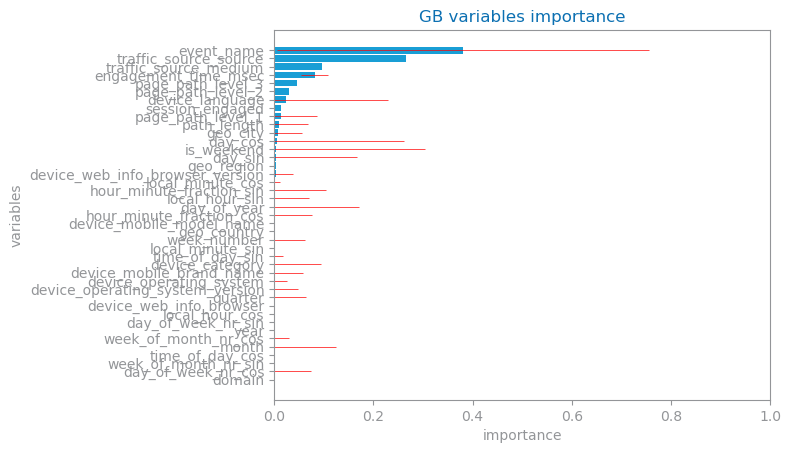

In [35]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_f2.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{f2_params["metric"]}_vars_ranking.png")

## f2 Overfitting

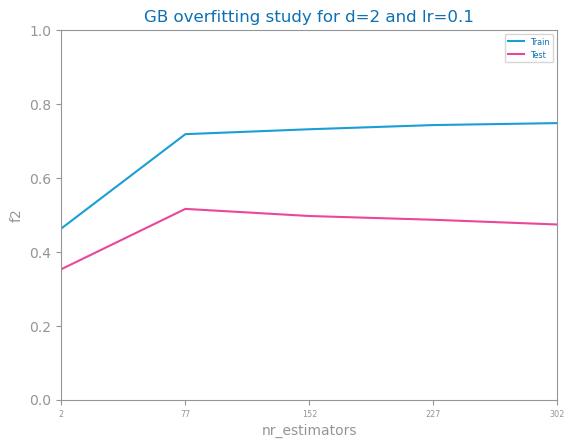

In [36]:

d_max: int = f2_params["params"][0]
lr: float = f2_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = f2_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Precision Evaluate for best model

## precision study

GB best for 100 trees (d=2 and lr=0.1


<Figure size 640x480 with 0 Axes>

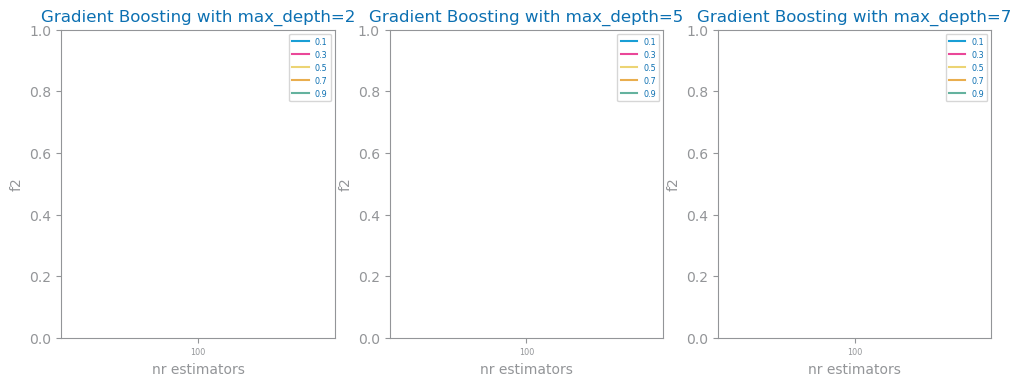

In [37]:
figure()


best_model_prec, prec_params = gradient_boosting_study(
trnX,
trnY,
tstX,
tstY,
nr_max_trees=max_trees_eval,
lag=max_trees_eval_lag,
metric='f2',
)

savefig(f'images/{file_tag}_GB_{prec_params['metric']}_study.png')
show()

## precision best model performance

<Figure size 640x480 with 0 Axes>

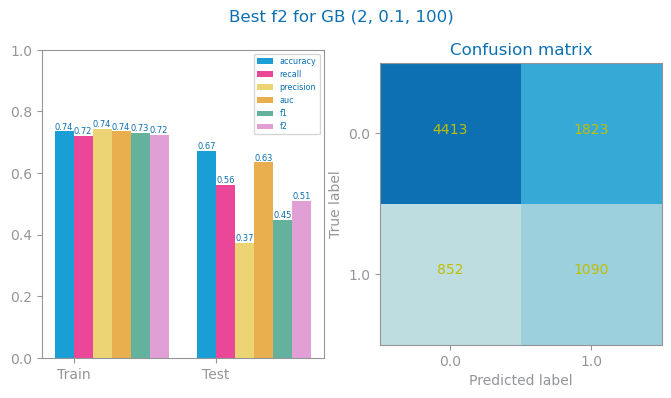

In [38]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels)
savefig(f'images/{file_tag}_GB_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## precision Variables importance


1. event_name (0.38060903866147416)
2. traffic_source_source (0.26439144971467854)
3. traffic_source_medium (0.09925446985220829)
4. engagement_time_msec (0.08146727560554669)
5. page_path_level_3 (0.047831964167753455)
6. page_path_level_2 (0.025180294556037784)
7. device_language (0.023362177430593538)
8. page_path_level_1 (0.015593527595477831)
9. session_engaged (0.0147612070057848)
10. path_length (0.009304185434355525)
11. geo_city (0.007368627514890118)
12. day_cos (0.006079675365607774)
13. is_weekend (0.004069108005131257)
14. day_sin (0.0036866200318614773)
15. geo_region (0.0033757633751967235)
16. device_web_info_browser_version (0.0029136210727392087)
17. local_minute_cos (0.002454107789526387)
18. hour_minute_fraction_sin (0.002291410078378356)
19. local_hour_sin (0.0018933492658121814)
20. day_of_year (0.0017634311988026247)
21. hour_minute_fraction_cos (0.0007645846989849739)
22. device_mobile_model_name (0.0006066106843121866)
23. geo_country (0.0005069294496398706)
24

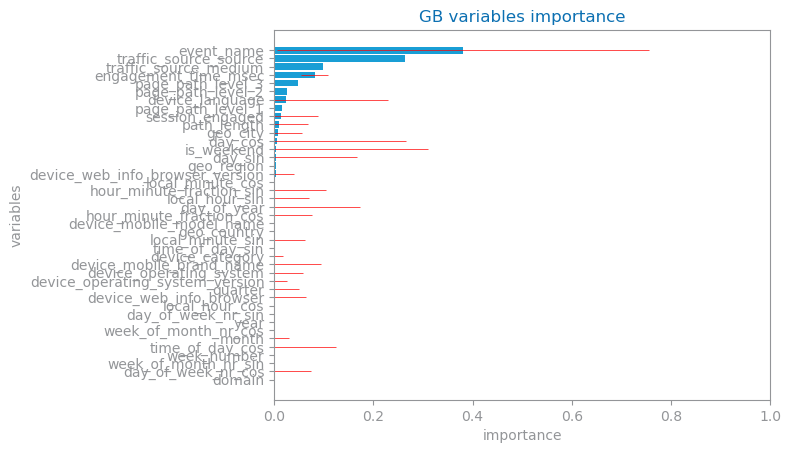

In [39]:
from numpy import std, argsort
from dslabs_functions import plot_horizontal_bar_chart

trees_importances: list[float] = []
for lst_trees in best_model_prec.estimators_:
    for tree in lst_trees:
        trees_importances.append(tree.feature_importances_)

stdevs: list[float] = list(std(trees_importances, axis=0))
importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values.append(importances[indices[f]])
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    error=stdevs,
    title="GB variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{prec_params["metric"]}_vars_ranking.png")

## precision overfitting

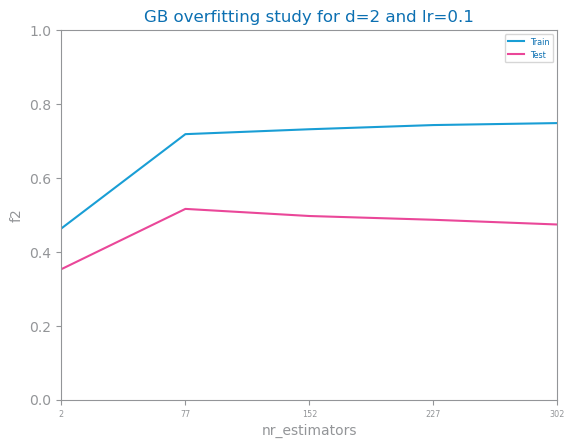

In [40]:

d_max: int = prec_params["params"][0]
lr: float = prec_params["params"][1]
nr_estimators: list[int] = [i for i in range(2, max_trees_eval, max_trees_eval_lag)]

y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric: str = prec_params['metric']

for n in nr_estimators:
    clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    nr_estimators,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"GB overfitting study for d={d_max} and lr={lr}",
    xlabel="nr_estimators",
    ylabel=str(eval_metric),
    percentage=True,
)
savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
